In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import warnings
import unidecode

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Embedding, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from sklearn.metrics import f1_score, confusion_matrix

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
sw = stopwords.words('english')
es=EarlyStopping(patience=4) 

## EDA

In [2]:
train = pd.read_csv('data/labeledTrainData.tsv', sep='\t')
test = pd.read_csv('data/testData.tsv', sep='\t')

train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
train.shape

(25000, 3)

Text(0, 0.5, 'Count')

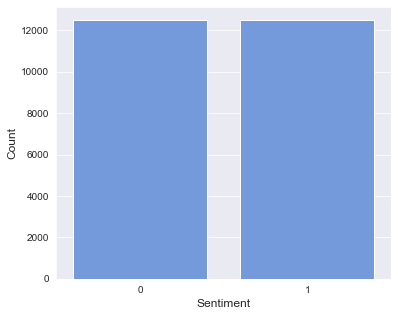

In [4]:
plt.figure(figsize=(6, 5))
sns.countplot(data=train, x='sentiment', color='cornflowerblue')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)

In [5]:
def check_stopwords(text):
    stopwords_founded = [word for word in text.split() if word in sw]
    return len(stopwords_founded)

In [6]:
data = train.copy()
data['review'] = data['review'].apply(str)
data['words'] = data['review'].apply(lambda x: len(x.split()))
data['characters'] = data['review'].apply(lambda x: len(x))
data['uppercase'] = data['review'].apply(lambda x: len(re.findall(r'[A-Z]', x)))
data['lowercase'] = data['review'].apply(lambda x: len(re.findall(r'[a-z]', x)))
data['stopwords'] = data['review'].apply(lambda x: check_stopwords(x))
data['special_characters'] = data['review'].apply(lambda x: len(re.findall(r'[^\s\w\d]', x)))
data['digits'] = data['review'].apply(lambda x: len(re.findall(r'\d', x)))
data['hyperlinks'] = data['review'].apply(lambda x: len(re.findall(r'\<.*\>', x)))
data['links'] = data['review'].apply(lambda x: len(re.findall(r'https?\:\/\/[^\s]+|www\.[^\s]+', x)))
data.head()

,id,sentiment,review,words,characters,uppercase,lowercase,stopwords,special_characters,digits,hyperlinks,links
0,5814_8,1,With all this stuff going down at the moment w...,433,2302,59,1742,190,67,2,1,0
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",158,946,26,721,69,42,0,0,0
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,378,2449,75,1907,118,77,13,1,0
3,3630_4,0,It must be assumed that those who praised this...,379,2245,35,1734,169,94,4,1,0
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,367,2231,37,1756,134,68,4,0,0


### Words

Text(0, 0.5, 'Count')

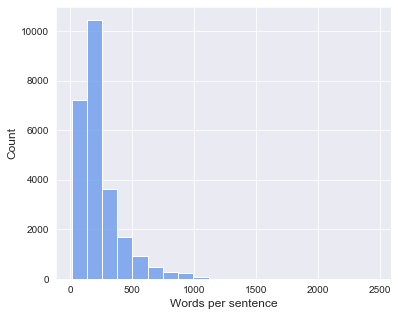

In [7]:
plt.figure(figsize=(6, 5))
sns.histplot(data=data, x='words', color='cornflowerblue', bins=20)
plt.xlabel('Words per sentence', fontsize=12)
plt.ylabel('Count', fontsize=12)

In [8]:
print('Median: {:.0f}'.format(data['words'].median()))
print('Max: {}'.format(max(data['words'])))

Median: 174
Max: 2470


### Characters

Text(0, 0.5, 'Count')

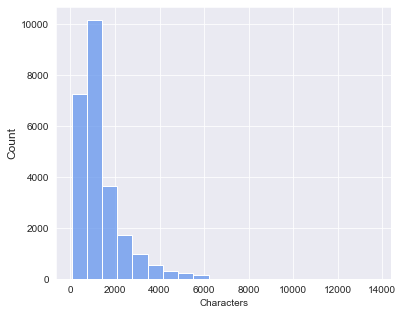

In [9]:
plt.figure(figsize=(6, 5))
sns.histplot(data=data, x='characters', color='cornflowerblue', bins=20)
plt.xlabel('Characters')
plt.ylabel('Count', fontsize=12)

In [10]:
print('Median: {:.0f}'.format(data['characters'].median()))
print('Max: {}'.format(max(data['characters'])))

Median: 981
Max: 13708


### Special Characters

Text(0, 0.5, 'Count')

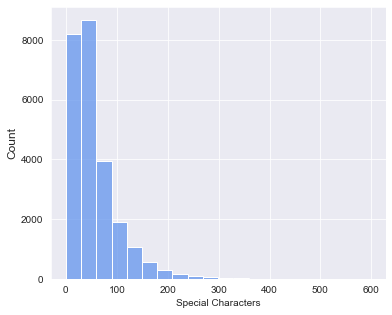

In [11]:
plt.figure(figsize=(6, 5))
sns.histplot(data=data, x='special_characters', color='cornflowerblue', bins=20)
plt.xlabel('Special Characters')
plt.ylabel('Count', fontsize=12)

In [12]:
print('Median: {:.0f}'.format(data['special_characters'].median()))
print('Max: {}'.format(max(data['special_characters'])))

Median: 42
Max: 598


### Uppercase

Text(0, 0.5, 'Count')

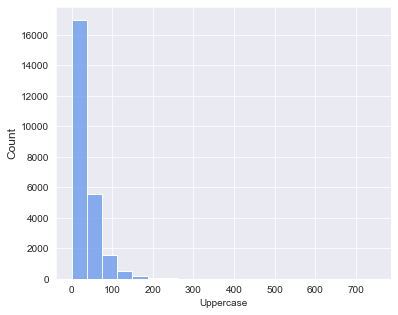

In [13]:
plt.figure(figsize=(6, 5))
sns.histplot(data=data, x='uppercase', color='cornflowerblue', bins=20)
plt.xlabel('Uppercase')
plt.ylabel('Count', fontsize=12)

In [14]:
print('Median: {:.0f}'.format(data['uppercase'].median()))
print('Max: {}'.format(max(data['uppercase'])))

Median: 26
Max: 749


### Lowercase

Text(0, 0.5, 'Count')

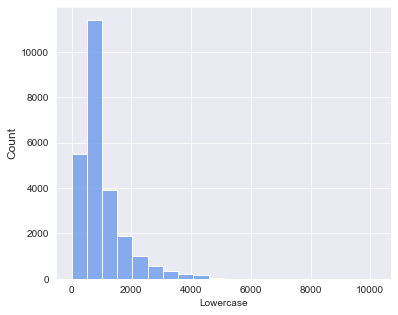

In [15]:
plt.figure(figsize=(6, 5))
sns.histplot(data=data, x='lowercase', color='cornflowerblue', bins=20)
plt.xlabel('Lowercase')
plt.ylabel('Count', fontsize=12)

In [16]:
print('Median: {:.0f}'.format(data['lowercase'].median()))
print('Max: {}'.format(max(data['lowercase'])))

Median: 737
Max: 10189


### Digits

Text(0, 0.5, 'Count')

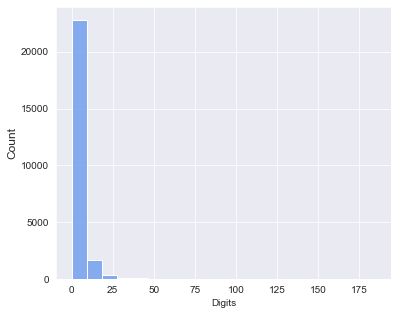

In [17]:
plt.figure(figsize=(6, 5))
sns.histplot(data=data, x='digits', color='cornflowerblue', bins=20)
plt.xlabel('Digits')
plt.ylabel('Count', fontsize=12)

In [18]:
print('Median: {:.0f}'.format(data['digits'].median()))
print('Max: {}'.format(max(data['digits'])))

Median: 2
Max: 185


### Stopwords

Text(0, 0.5, 'Count')

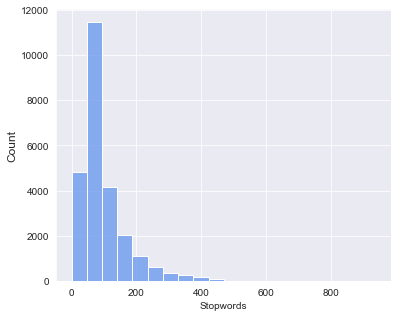

In [19]:
plt.figure(figsize=(6, 5))
sns.histplot(data=data, x='stopwords', color='cornflowerblue', bins=20)
plt.xlabel('Stopwords')
plt.ylabel('Count', fontsize=12)

In [20]:
print('Median: {:.0f}'.format(data['stopwords'].median()))
print('Max: {}'.format(max(data['stopwords'])))

Median: 72
Max: 938


### Hyperlinks

Text(0, 0.5, 'Count')

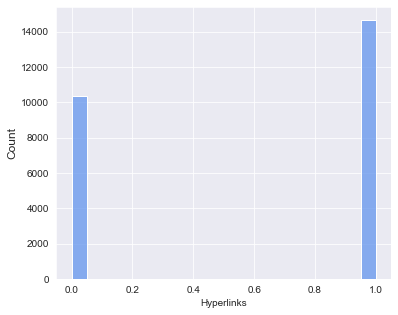

In [21]:
plt.figure(figsize=(6, 5))
sns.histplot(data=data, x='hyperlinks', color='cornflowerblue', bins=20)
plt.xlabel('Hyperlinks')
plt.ylabel('Count', fontsize=12)

In [22]:
print('Median: {:.0f}'.format(data['hyperlinks'].median()))
print('Max: {}'.format(max(data['hyperlinks'])))

Median: 1
Max: 1


### Links

Text(0, 0.5, 'Count')

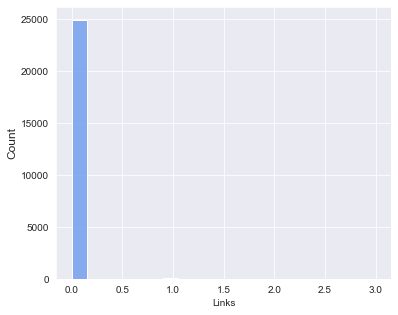

In [23]:
plt.figure(figsize=(6, 5))
sns.histplot(data=data, x='links', color='cornflowerblue', bins=20)
plt.xlabel('Links')
plt.ylabel('Count', fontsize=12)

In [24]:
print('Median: {:.0f}'.format(data['links'].median()))
print('Max: {}'.format(max(data['links'])))

Median: 0
Max: 3


In [25]:
del data

## Preprocessing

In [26]:
def remove_stopwords(text):
    non_stopwords = [word for word in text.split() if word not in sw]
    return ' '.join(non_stopwords)

def remove_digits(text):
    non_digits = re.sub(r'\d+', ' ', text)
    return non_digits

def format_spaces(text):
    spaces_formated = re.sub(r'\s+', ' ', text)
    spaces_formated = spaces_formated.strip()
    return spaces_formated

def remove_accents(text):
    no_accents = unidecode.unidecode(text)
    return no_accents

def remove_specials(text):
    no_special_characters = re.sub(r'[^\s\w\d]+', ' ', text)
    return no_special_characters

def remove_one_len_word(text):
    no_one_len_word = re.sub(r'\b[a-z]\b', ' ', text)
    return no_one_len_word

def remove_hyperlinks(text):
    no_hyperlink = re.sub(r'\<.*\>', ' ', text)
    return no_hyperlink

def remove_links(text):
    text = re.sub(r'http\:\/\/[^\s]+', ' ', text)
    text = re.sub(r'www\.[^\s]+', ' ', text)
    return text
    
def preprocessing(data):
    data = pd.Series(data)
    data = data.apply(str)
    data = data.apply(remove_hyperlinks)
    data = data.apply(remove_links)
    data = data.apply(lambda x: x.lower())
    data = data.apply(remove_digits)
    data = data.apply(remove_accents)
    data = data.apply(remove_specials)
    data = data.apply(remove_stopwords)
    data = data.apply(remove_one_len_word)
    data = data.apply(format_spaces)
    return data

In [27]:
%%time
train['review_cleaned'] = train['review'].apply(preprocessing)
train = train.drop_duplicates()
train = train.dropna()
train.shape

CPU times: user 1min 10s, sys: 372 ms, total: 1min 11s
Wall time: 1min 11s


(25000, 4)

In [28]:
train.head(10)

,id,sentiment,review,review_cleaned
0,5814_8,1,With all this stuff going down at the moment w...,stuff going moment mj started listening music ...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war worlds timothy hines entertaining ...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film starts manager nicholas bell giving welco...
3,3630_4,0,It must be assumed that those who praised this...,must assumed praised film greatest filmed oper...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious explo...
5,8196_8,1,I dont know why people think this is such a ba...,dont know people think bad movie got pretty go...
6,7166_2,0,"This movie could have been very good, but come...",movie could good comes way short cheesy specia...
7,10633_1,0,I watched this video at a friend's house. I'm ...,watched video friend house glad waste money bu...
8,319_1,0,"A friend of mine bought this film for £1, and ...",friend mine bought film PS even grossly overpr...
9,8713_10,1,<br /><br />This movie is full of references. ...,movie full references like mad max ii wild one...


In [29]:
train['len_before'] = train['review'].apply(lambda x: len(x.split()))
train['len_after'] = train['review_cleaned'].apply(lambda x: len(x.split()))

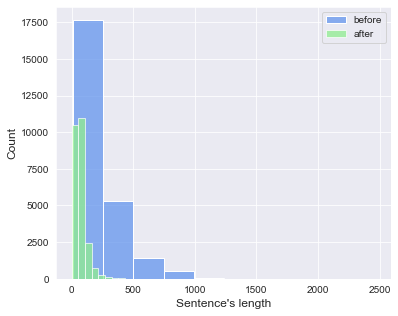

In [30]:
plt.figure(figsize=(6, 5))
sns.histplot(data=train, x='len_before', color='cornflowerblue', label='before', bins=10)
sns.histplot(data=train, x='len_after', color='lightgreen', label='after', bins=10)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Sentence's length", fontsize=12)
plt.legend()

In [31]:
print('----- Before -----')
print('Median: {:.0f}'.format(train['len_before'].median()))
print('Max: {}'.format(max(train['len_before'])))
print('\n----- After -----')
print('Median: {:.0f}'.format(train['len_after'].median()))
print('Max: {}'.format(max(train['len_after'])))

----- Before -----
Median: 174
Max: 2470

----- After -----
Median: 61
Max: 544


In [32]:
max_words = 60

In [33]:
train = train.drop(columns=['len_before', 'len_after', 'id'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['review_cleaned'])
train['review_tokenized'] = tokenizer.texts_to_sequences(train['review_cleaned'])
train.head()

,sentiment,review,review_cleaned,review_tokenized
0,1,With all this stuff going down at the moment w...,stuff going moment mj started listening music ...,"[377, 74, 569, 9497, 459, 2620, 113, 46, 885, ..."
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war worlds timothy hines entertaining ...,"[181, 218, 2906, 3220, 5809, 256, 2, 406, 191,..."
2,0,The film starts with a manager (Nicholas Bell)...,film starts manager nicholas bell giving welco...,"[2, 418, 3003, 4031, 3331, 613, 2271, 19059, 4..."
3,0,It must be assumed that those who praised this...,must assumed praised film greatest filmed oper...,"[87, 4556, 4280, 2, 563, 608, 1221, 30, 177, 1..."
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious explo...,"[3152, 3262, 35853, 9144, 1701, 11801, 1450, 7..."


In [34]:
total_words = len(tokenizer.word_index) + 1
total_words

57992

In [35]:
sequences_padded = pad_sequences(train['review_tokenized'], maxlen=max_words, padding='post')
sequences_padded.shape

(25000, 60)

In [36]:
sequences_padded

array([[ 1495,    13,  4279, ..., 19058,   260,  1381],
       [ 5809,  2664,   131, ...,  1099, 10288,  4928],
       [16069,  5482,  1889, ...,   638,   990,  4555],
       ...,
       [  136,  3005,    20, ...,    20,   213,     0],
       [ 3037,  1458,  3178, ...,   232,  1746,    16],
       [ 5295,  4932,    35, ...,   815,    72,   359]], dtype=int32)

## Model

In [37]:
model = Sequential()
model.add(Embedding(input_dim=total_words,
                    output_dim=50,
                    input_length=max_words))
model.add(Conv1D(filters=32,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64,
                 kernel_size=5,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(units=64,
                activation='relu'))
model.add(Dense(units=1,
                activation='sigmoid'))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 50)            2899600   
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 32)            4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 64)            10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 960)               0

### Training

In [39]:
X = sequences_padded
y = train['sentiment']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [41]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
%%time
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=15,
                    validation_data=[X_test, y_test],
                    callbacks=[es])

Epoch 1/15
625/625 [==============================] - 44s 50ms/step - loss: 0.5866 - accuracy: 0.6252 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
625/625 [==============================] - 30s 48ms/step - loss: 0.1964 - accuracy: 0.9236 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/15
625/625 [==============================] - 29s 47ms/step - loss: 0.0602 - accuracy: 0.9815 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/15
625/625 [==============================] - 30s 47ms/step - loss: 0.0175 - accuracy: 0.9949 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/15
625/625 [==============================] - 29s 47ms/step - loss: 0.0091 - accuracy: 0.9973 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
CPU times: user 6min 24s, sys: 21.7 s, total: 6min 46s
Wall time: 2min 42s


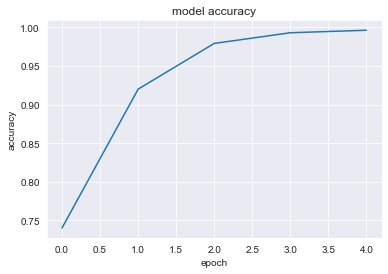

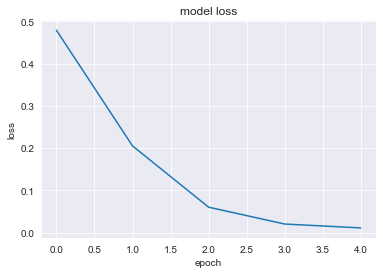

In [43]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [44]:
loss, score = model.evaluate(X_test, y_test, batch_size=32, verbose=0)

print("Model's Loss: {:.4f} \nModel's Score: {:.4f}".format(loss, score))

Model's Loss: 1.1376 
Model's Score: 0.8212


In [45]:
predicted = model.predict_classes(X_test, batch_size=32)
print('F1-score: {:.4f}'.format(f1_score(predicted, y_test)))

F1-score: 0.8148


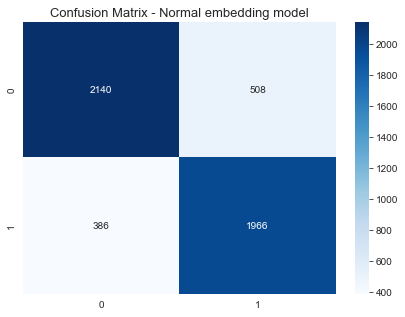

In [46]:
plt.figure(figsize=(7, 5))
plt.title('Confusion Matrix - Normal embedding model', fontsize=13)
sns.heatmap(confusion_matrix(predicted, y_test), annot = True, fmt='.4g', cmap='Blues')

## Glove Embedding

In [47]:
def loadGloveModel(file):
    f = open(file,'r')
    model = dict()
    
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        embedding = np.array([float(value) for value in splitLines[1:]])
        model[word] = embedding
    
    return model

In [48]:
%%time
glove = loadGloveModel('glove.6B.300d.txt')

CPU times: user 37.5 s, sys: 1.01 s, total: 38.5 s
Wall time: 38.5 s


In [49]:
embedding = np.zeros((total_words, 300))

for word, index in tokenizer.word_index.items():
    try:
        embedding[index] = glove[word]
    except:
        continue

In [50]:
model_glove = Sequential()
model_glove.add(Embedding(input_dim=total_words, 
                output_dim=300, 
                input_length=max_words,
                weights=[embedding],
                trainable=False))
model_glove.add(Conv1D(filters=32,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
model_glove.add(MaxPooling1D())
model_glove.add(Conv1D(filters=64,
                 kernel_size=5,
                 padding='same',
                 activation='relu'))
model_glove.add(MaxPooling1D())
model_glove.add(Dropout(rate=0.2))
model_glove.add(Flatten())
model_glove.add(Dense(units=64,
                activation='relu'))
model_glove.add(Dense(units=1,
                activation='sigmoid'))

In [51]:
model_glove.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

### Training

In [52]:
%%time
history = model_glove.fit(X_train,
                          y_train,
                          batch_size=32,
                          epochs=15,
                          validation_data=[X_test, y_test],
                          callbacks=[es])

Epoch 1/15
625/625 [==============================] - 11s 15ms/step - loss: 0.5626 - accuracy: 0.6858 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
625/625 [==============================] - 9s 15ms/step - loss: 0.3899 - accuracy: 0.8244 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/15
625/625 [==============================] - 9s 15ms/step - loss: 0.3367 - accuracy: 0.8514 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/15
625/625 [==============================] - 10s 16ms/step - loss: 0.2621 - accuracy: 0.8934 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/15
625/625 [==============================] - 10s 15ms/step - loss: 0.2108 - accuracy: 0.9183 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
CPU times: user 1min 52s, sys: 4.23 s, total: 1min 56s
Wall time: 49.1 s


In [53]:
loss, score = model_glove.evaluate(X_test, y_test, batch_size=32, verbose=0)

print("GloVe's model Loss: {:.4f} \nGloVe's model Score: {:.4f}".format(loss, score))

GloVe's model Loss: 0.5008 
GloVe's model Score: 0.8076


In [54]:
predicted = model_glove.predict_classes(X_test, batch_size=32)
print('F1-score: {:.4f}'.format(f1_score(predicted, y_test)))

F1-score: 0.8136


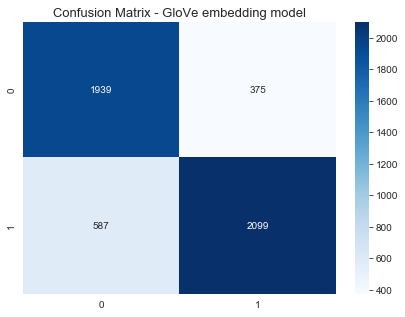

In [55]:
plt.figure(figsize=(7, 5))
plt.title('Confusion Matrix - GloVe embedding model', fontsize=13)
sns.heatmap(confusion_matrix(predicted, y_test), annot = True, fmt='.4g', cmap='Blues')

## Predicting

In [56]:
test_id = test['id']
test = test.drop(columns=['id'])
test.shape

(25000, 1)

In [57]:
%%time
test['review_cleaned'] = test['review'].apply(preprocessing)
test.head()

CPU times: user 1min 20s, sys: 441 ms, total: 1min 20s
Wall time: 1min 21s


,review,review_cleaned
0,Naturally in a film who's main themes are of m...,naturally film main themes mortality nostalgia...
1,This movie is a disaster within a disaster fil...,movie disaster within disaster film full great...
2,"All in all, this is a movie for kids. We saw i...",movie kids saw tonight child loved one point k...
3,Afraid of the Dark left me with the impression...,afraid dark left impression several different ...
4,A very accurate depiction of small time mob li...,accurate depiction small time mob life filmed ...


In [58]:
test['review_tokenized'] = tokenizer.texts_to_sequences(test['review_cleaned'])
test.head()

,review,review_cleaned,review_tokenized
0,Naturally in a film who's main themes are of m...,naturally film main themes mortality nostalgia...,"[1827, 2, 204, 1212, 14350, 4244, 1925, 3057, ..."
1,This movie is a disaster within a disaster fil...,movie disaster within disaster film full great...,"[1, 1341, 699, 1341, 2, 250, 14, 101, 55, 3173..."
2,"All in all, this is a movie for kids. We saw i...",movie kids saw tonight child loved one point k...,"[1, 227, 72, 3839, 359, 243, 3, 134, 378, 2171..."
3,Afraid of the Dark left me with the impression...,afraid dark left impression several different ...,"[1486, 322, 202, 1253, 321, 159, 6912, 255, 21..."
4,A very accurate depiction of small time mob li...,accurate depiction small time mob life filmed ...,"[1461, 2500, 277, 6, 3031, 35, 608, 65, 6816, ..."


In [59]:
test_padded = pad_sequences(test['review_tokenized'], maxlen=max_words, padding='post')
test_padded

array([[  307,   790,   605, ...,  4448,  4069,   758],
       [18461, 21394,  1327, ...,     6,  3173,  1375],
       [  134,   378,  2171, ...,   253, 22281,   282],
       ...,
       [  659, 23806,  1755, ...,   154,    11,   470],
       [  561,   727,   901, ...,     0,     0,     0],
       [  834,   464,   242, ...,   112,  1405,     3]], dtype=int32)

In [60]:
test_padded.shape

(25000, 60)

In [61]:
predicted = model_glove.predict_classes(test_padded, batch_size=32)

prediction = pd.DataFrame()
prediction['id'] = test_id
prediction['sentiment'] = predicted
prediction.head()

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


Text(0, 0.5, 'Sentiment')

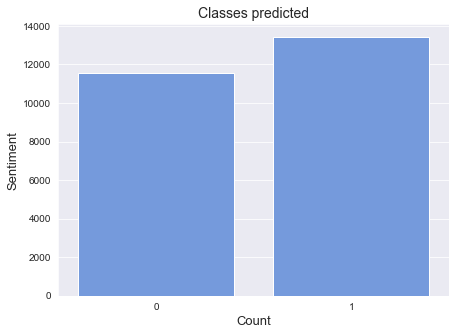

In [62]:
plt.figure(figsize=(7, 5))
plt.title('Classes predicted', fontsize=14)
sns.countplot(data=prediction, x='sentiment', color='cornflowerblue')
plt.xlabel('Count', fontsize=13)
plt.ylabel('Sentiment', fontsize=13)

In [63]:
prediction.to_csv('submission2.csv', index=False)